In [1]:
# %load /Users/erik/defaults.py
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import modeling

%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# http://dan.iel.fm/george
#import george

PM expectations from http://arxiv.org/abs/0805.2366, TAble 3, pg 22 (in v4)

In [3]:
lsst_expected = Table()

lsst_expected['r'] = [21, 22 ,23, 24]*u.mag
lsst_expected['r'].description = 'magnitude of target'

lsst_expected['sig_xy'] = [11, 15, 31, 74]*u.mas
lsst_expected['sig_xy'].description = 'Typical astrometric accuracy (rms per coordinate per visit)'

lsst_expected['sig_pi'] = [0.6, 0.8, 1.3, 2.9]*u.mas
lsst_expected['sig_pi'].description = 'Parallax accuracy for 10 year long survey'

lsst_expected['sig_mu'] = [0.2, 0.3, 0.5, 1.]*u.mas/u.yr
lsst_expected['sig_mu'].description = 'Proper motion accuracy for 10 year long survey'

lsst_expected['sig_1'] = [0.01, 0.02, 0.04, 0.1]*u.mag
lsst_expected['sig_1'].description = 'Photometric error for single visit'

lsst_expected['sig_C'] = [0.005, 0.005, 0.006, 0.009]*u.mag
lsst_expected['sig_C'].description = 'Photometric error for coadded observations'

# First figure out how to map from point-source PMs to bulk PMs 

<PowerLaw1D(amplitude=0.15497442638492737, x_0=21.0, alpha=-13.836555526351784)>

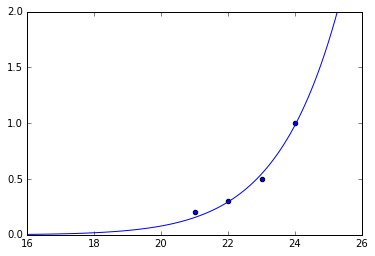

In [4]:
pl = modeling.models.PowerLaw1D(x_0=21, amplitude=.2, alpha=-15)
pl.x_0.fixed = True
pl = modeling.fitting.LevMarLSQFitter()(pl, lsst_expected['r'], lsst_expected['sig_mu'])


xs = np.linspace(16,26,100)
plt.scatter(lsst_expected['r'], lsst_expected['sig_mu'])
plt.plot(xs, pl(xs))
plt.xlim(xs[0], xs[-1])
plt.ylim(0,2)
pl

In [5]:
def pm_from_nstars(rs, distance=None):
    pm_errs = pl(rs.to(lsst_expected['r'].unit).value)*lsst_expected['sig_mu'].unit
    pm_std = np.sum(pm_errs**2)**0.5 * pm_errs.size**-1
    if distance is None:
        return pm_std
    else:
        return (pm_std*distance).to(u.km/u.s, u.dimensionless_angles())